## HANDWRITTEN OCR

In [3]:
!pip install opencv-python

In [4]:
import tensorflow as tf

Train data shape:  (297960, 28, 28)
Test data shape:  (74490, 28, 28)


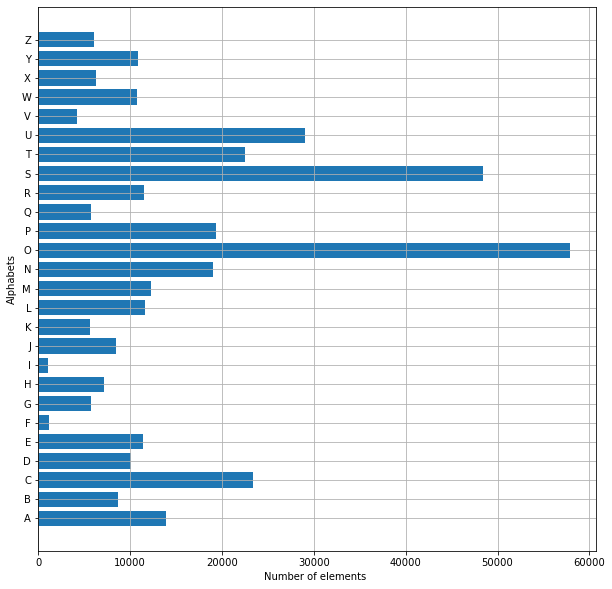

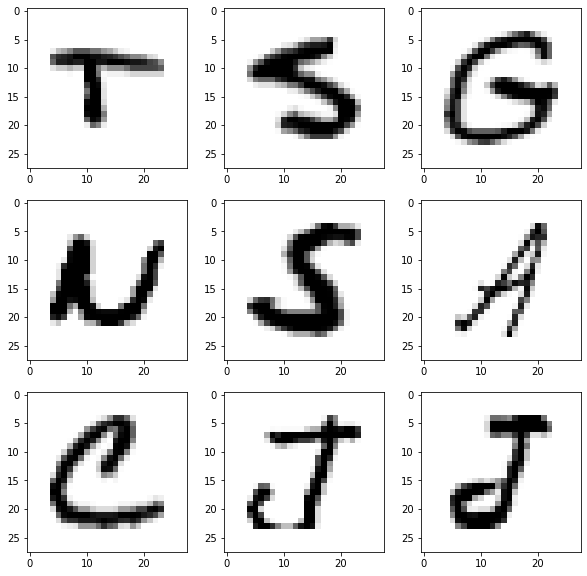

New shape of train data:  (297960, 28, 28, 1)
New shape of train data:  (74490, 28, 28, 1)
New shape of train labels:  (297960, 26)
New shape of test labels:  (74490, 26)
4486/9312 [=============>................] - ETA: 2:34 - loss: 0.2266 - accuracy: 0.9374

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.utils import shuffle



# Read the data...
data = pd.read_csv(r"A_Z Handwritten Data.csv").astype('float32')

# Split data the X - Our data , and y - the prdict label
X = data.drop('0',axis = 1)
y = data['0']


# Reshaping the data in csv file so that it can be displayed as an image...

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28))


print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

# Dictionary for getting characters from index values...
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}


# Plotting the number of alphabets in the dataset...

train_yint = np.int0(y)
count = np.zeros(26, dtype='int')
for i in train_yint:
    count[i] +=1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphabets")
plt.grid()
plt.show()


#Shuffling the data ...
shuff = shuffle(train_x[:100])

fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()


#Reshaping the training & test dataset so that it can be put in the model...

train_X = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
print("New shape of train data: ", train_X.shape)

test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2],1)
print("New shape of train data: ", test_X.shape)


# Converting the labels to categorical values...

train_yOHE = to_categorical(train_y, num_classes = 26, dtype='int')
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(test_y, num_classes = 26, dtype='int')
print("New shape of test labels: ", test_yOHE.shape)


# CNN model...

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(26,activation ="softmax"))



model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history = model.fit(train_X, train_yOHE, epochs=1, callbacks=[reduce_lr, early_stop],  validation_data = (test_X,test_yOHE))


model.summary()
model.save(r'model_hand.h5')


# Displaying the accuracies & losses for train & validation set...

print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])



#Making model predictions...

pred = model.predict(test_X[:9])
print(test_X.shape)


# Displaying some of the test images & their predicted labels...

fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(test_X[i], (28,28))
    ax.imshow(img, cmap="Greys")
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()


# Prediction on external image...

img = cv2.imread(r'C:\Users\sharm\TEST_DATA.jpg')
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
img_final =np.reshape(img_final, (1,28,28,1))


img_pred = word_dict[np.argmax(model.predict(img_final))]

cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
cv2.imshow('Dataflair handwritten character recognition _ _ _ ', img)


while (1):
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

